# Usando LittleVGG  para Deteccion de Emociones

### Importando las dependencias necesarias

In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,Dropout
from keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [2]:
num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 16

train_data_dir = './fer2013/train'
validation_data_dir = './fer2013/validation'

# vamos a usar algnos argumentos para los datos
train_datagen = ImageDataGenerator(
      rescale=1./255, # cada pixel es divido entre 255
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
    
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


## Keras Modelo LittleVGG

In [3]:
from keras import regularizers
model = Sequential()
#Block #1
model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer='random_uniform',
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer='random_uniform', 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="random_uniform"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="random_uniform"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="random_uniform"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="random_uniform"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="random_uniform"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="random_uniform"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# # Block #4: third CONV => RELU => CONV => RELU => POOL
# # layer set
# model.add(Conv2D(512, (3, 3), padding="same", kernel_initializer="random_uniform"))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(512, (3, 3), padding="same", kernel_initializer="random_uniform"))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="random_uniform", kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="random_uniform", kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="random_uniform", kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation("softmax"))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
__________

## Entrenar Modelo

In [4]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("/home/jesus/DeepLearningCV/Trained Models/emotion_little_vgg_29.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# ANADIR AL CALLBACK A UN VECTOR
callbacks = [earlystop, checkpoint, reduce_lr]

# VAMOS A USAR UN APRENDIZAJE PEQUENOO
model.compile(loss = 'categorical_crossentropy',
#               optimizer = "sgd",
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

nb_train_samples = 28709
nb_validation_samples = 3589

epochs = 5

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples,
#     steps_per_epoch = nb_train_samples// batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
#     validation_steps = nb_validation_samples // batch_size)
     validation_steps = nb_validation_samples)

Epoch 1/5
28709/28709 [==============================] - 4679s 163ms/step - loss: 1.7579 - acc: 0.3262 - val_loss: 1.5961 - val_acc: 0.4288

Epoch 00001: val_loss improved from inf to 1.59609, saving model to /home/jesus/DeepLearningCV/Trained Models/emotion_little_vgg_29.h5
Epoch 2/5
28709/28709 [==============================] - 4516s 157ms/step - loss: 1.5434 - acc: 0.4532 - val_loss: 1.6130 - val_acc: 0.4819

Epoch 00002: val_loss did not improve from 1.59609
Epoch 3/5
28709/28709 [==============================] - 4533s 158ms/step - loss: 1.4828 - acc: 0.4852 - val_loss: 1.5811 - val_acc: 0.4781

Epoch 00003: val_loss improved from 1.59609 to 1.58111, saving model to /home/jesus/DeepLearningCV/Trained Models/emotion_little_vgg_29.h5
Epoch 4/5
28709/28709 [==============================] - 5415s 189ms/step - loss: 1.4497 - acc: 0.5043 - val_loss: 1.5966 - val_acc: 0.4754

Epoch 00004: val_loss did not improve from 1.58111
Epoch 5/5
28709/28709 [==============================] - 500

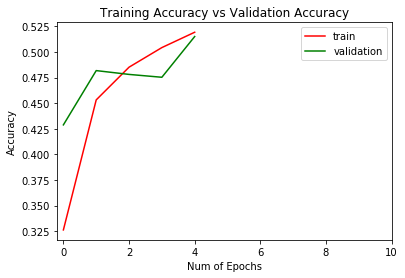

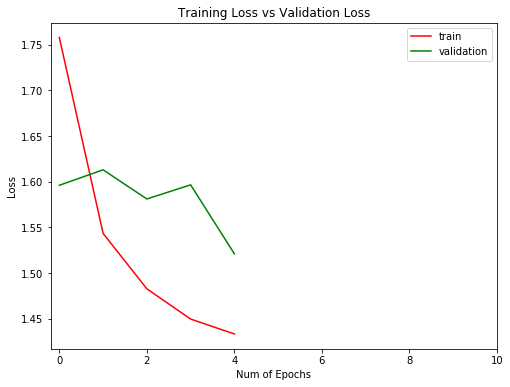

In [19]:
import matplotlib.pyplot as plt
plt.figure(0)  
plt.plot(history.history['acc'],'r')  
plt.plot(history.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])
plt.show()  

In [21]:
print("Entrenando exactitud vs prueba exactitud")
print(history.history['acc'])
print(history.history['val_acc'])

print('')

print("Entrenando perdida vs prueba perdida")
print(history.history['loss'])
print(history.history['val_loss'])

Entrenando exactitud vs prueba exactitud
[0.32617563085517204, 0.45324151508981453, 0.4852036727315594, 0.5043600599361129, 0.5193545717486204]
[0.4288234164235907, 0.4818683622283637, 0.4781477082301558, 0.47535285077439365, 0.5151621017564981]

Entrenando perdida vs prueba perdida
[1.7579255463721175, 1.5434372075396894, 1.482756864378424, 1.4496353290861121, 1.4333186674655662]
[1.5960941285706376, 1.6130343719456883, 1.5811083146978469, 1.596587700611048, 1.5210782558927411]


# Matriz de confusion

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 28709
nb_validation_samples = 3589


class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')

print(classification_report(validation_generator.classes, y_pred, target_names=classes))

Confusion Matrix
[[102   0  17 145  89  83  55]
 [  9   0   4  15   9  10   8]
 [114   0  21 149 101  82  61]
 [181   0  35 248 169 144 102]
 [141   0  22 172 104 108  79]
 [123   0  17 171 112  95  76]
 [ 94   0   9 107  84  61  61]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.13      0.21      0.16       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.17      0.04      0.06       528
       Happy       0.25      0.28      0.26       879
     Neutral       0.16      0.17      0.16       626
         Sad       0.16      0.16      0.16       594
    Surprise       0.14      0.15      0.14       416

   micro avg       0.18      0.18      0.18      3589
   macro avg       0.14      0.14      0.14      3589
weighted avg       0.17      0.18      0.17      3589



/home/jesus/anaconda3/envs/App-330/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
